In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

import ot

import geomstats
from geomstats.geometry.spd_matrices import SPDMatrices

from dtmrpy import DT_GMM

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, LeaveOneOut

INFO: Using numpy backend


In [2]:
class dtgmm:
    def __init__(self, weights, locations):
        assert weights.shape[0] == locations.shape[0]
        self.weights = weights
        self.locations = locations
     
    def means_(self):
        return self.locations[:,:3]
    
    def covariances_(self):
        C = self.locations[:,3:]
        return np.array([C[:,0],C[:,1]/2,C[:,2]/2,C[:,1]/2,C[:,3],C[:,4]/2,C[:,2]/2,C[:,4]/2,C[:,5]]).T.reshape(-1,3,3)
        
    def plot_gmm(self):
        w = self.weights/max(self.weights)
        x,y,z = self.locations[:,0],self.locations[:,1],self.locations[:,2]
        c = np.array([self.locations[:,3],self.locations[:,6],self.locations[:,8]]).T
        c=c/(np.sum(c,1).reshape(-1,1))
 
        for i in range(w.shape[0]):
            plt.plot(x[i],y[i],z[i],'.',c=c[i],alpha = w[i])
            
        # plt.gca().scatter(x,y,z,s=8,c=c, alpha = w) # much faster, but renders differently

def DT_GMM_to_dtgmm(DT_GMM):
    w = DT_GMM.weights_.reshape(-1)
    weights = w/sum(w)
    
    x = DT_GMM.means_
    x = x-np.mean(x,0)
    cov_temp = geomstats.geometry.spd_matrices.SPDMatrices(3).projection(DT_GMM.covariances_)
    C = (cov_temp.reshape(-1,9)[:,np.array([0,1,2,4,5,8])])*(np.array([1,2,2,1,2,1]).reshape(1,-1))   
    locations = np.concatenate([x,C],1)
    
    return dtgmm(weights, locations)

def dtgmm_to_DT_GMM(dtgmm):
    weights_ = dtgmm.weights
    means_ = dtgmm.locations[:,:3]
    dtgmm.covariances_
    return DT_GMM(weights_,means_,covarinaces_)

In [3]:
class free_support_barycenter(dtgmm):
    
    def __init__(self,barycenter=None, N=200, lr=0.0000001):
        self.lr=lr #learning rate for weights update
        
        if barycenter==None:
            init_weights = np.ones(N)/N
            x = np.zeros(3)+np.random.normal(size=(N,3))
            cov_temp = geomstats.geometry.spd_matrices.SPDMatrices(3).random_point(N)
            C = (cov_temp.reshape(-1,9)[:,np.array([0,1,2,4,5,8])])*(np.array([1,2,2,1,2,1]).reshape(1,-1)) 
            init_locations = np.concatenate([x,C],1)
            
            super().__init__(init_weights, init_locations)
            self.N = N
        
        else:
            super().__init__(barycenter.weights, barycenter.locations)
            self.N = barycenter.weights.shape[0]
               
    def get_barycentric_projection_embedding(self, measures_list):
        self.M_list = [np.square(cdist(self.locations,measure.locations)) for measure in measures_list]
        #calculate optimal couplings and optimal dual variables
        result_list = [ot.emd(self.weights,measure.weights,self.M_list[i],log=True) for i, measure in enumerate(measures_list)]
        #store optimal couplings
        self.Pi_list = [result[0] for result in result_list]
        #store optimal dual variables - center_ot_dual can probably just be replaced with result[1]['u']-np.mean(result[1]['u'])
        self.alpha_list = [ot.lp.center_ot_dual(result[1]['u'],result[1]['v'])[0] for result in result_list]
        #calculate and store barycentric projection locations
        self.embedding = np.array([(measures_list[i].locations.T@self.Pi_list[i].T@np.diag(1/self.weights.reshape(-1))).T for i in range(len(measures_list))])

    def weights_update(self):
        #get subgradient
        alpha = np.mean(np.array(self.alpha_list),0)
        #calculate subgradient update
        a_star = self.weights+(self.lr*alpha.reshape(1,-1))
        #project a_star into (interior of) probability simplex
        a_star[a_star<0]=1e-8
        a = a_star/np.sum(a_star)

        return a.reshape(-1)
        
    def free_support_barycenter_update(self, measures_list):
        self.get_barycentric_projection_embedding(measures_list)
        self.locations = np.mean(self.embedding,0)
        self.weights = self.weights_update()
        # print(np.mean(np.square(np.linalg.norm(barycenter.pseudo_log(),axis=1))))
        
    def pseudo_log(self):
        #calculate vector field representations
        return (self.embedding - self.locations).reshape(-1,self.N*9)
    
    def fit(self, measures_list, K=10, plot_steps=False):
        
        for i in range(K):
            self.free_support_barycenter_update(measures_list)
            
            if plot_steps:
                plt.figure().add_subplot(projection='3d')
                barycenter.plot_gmm()
                plt.gca().view_init(35,135)
                plt.show()
        

In [4]:
df = np.load('D:/DTMRI/HCP/hcp_centered_full_MZ_removed.pkl', allow_pickle=True)
df = df.dropna(subset=df.columns[2:-1],how='all').copy()
df.reset_index(inplace=True, drop=True)
# df

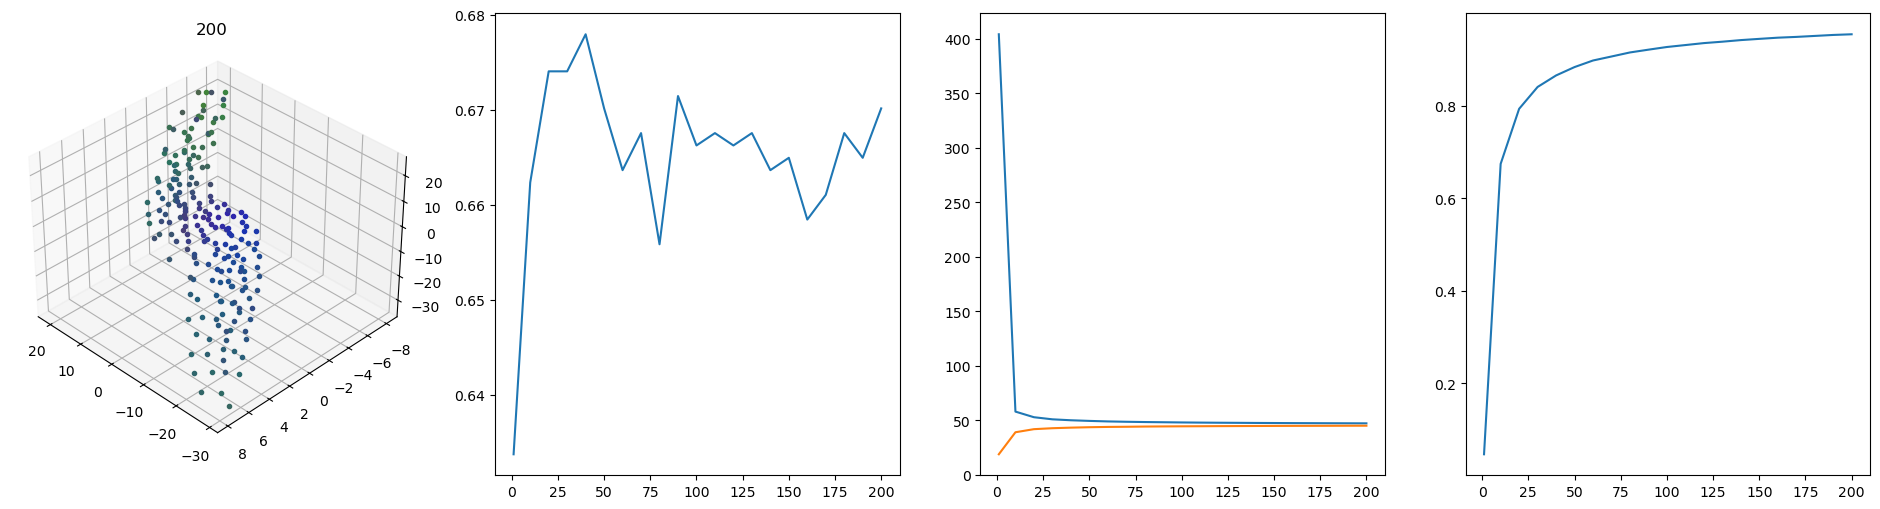

In [8]:
from IPython.display import clear_output

K = np.concatenate((np.array([1]),np.arange(10,201,10)))
# K = np.arange(500,1000,100)

tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])

for tract in tract_list[:7]:
    
    #get tract data
    ind = df[tract].dropna().index
    measure_list = list(df[tract][ind])
    dtgmm_list = [DT_GMM_to_dtgmm(measure) for measure in measure_list]
    y = np.array((df['label'][ind]=='M').astype(int))

    acc=np.zeros(len(K))
    deterministic_component=np.zeros(len(K))
    squared_wasserstein=np.zeros(len(K))

    for i, k in enumerate(K):

        #initialize barycenter with k support points
        barycenter = free_support_barycenter(N=k)

        #fit k-support barycenter to data
        barycenter.fit(dtgmm_list)

        #build classifier
        X = (barycenter.embedding - barycenter.locations)[:,:,3:].reshape(len(y),-1)
        temp =  np.mean(cross_val_score(SVC(),X,y,cv=LeaveOneOut()))
        acc[i] = temp


        #plot results of classifier and decomposition   
        clear_output(wait=True)
        plt.figure(figsize=(24,6)).add_subplot(141,projection='3d')
        barycenter.plot_gmm()
        plt.gca().view_init(35,135)
        plt.title(str(k))

        plt.subplot(142)
        plt.plot(K[acc>0],acc[acc>0])

        plt.subplot(143)
        deterministic_component[i] = np.mean(np.square(np.linalg.norm(barycenter.embedding-barycenter.locations,axis=2))@barycenter.weights)
        squared_wasserstein[i] = np.mean([np.sum(barycenter.M_list[i]*barycenter.Pi_list[i]) for i in range(len(barycenter.M_list))])

        plt.plot(K, squared_wasserstein)
        plt.plot(K, deterministic_component)

        plt.plot()

        plt.subplot(144)
        plt.plot(K,deterministic_component/(squared_wasserstein+1e-10))

        plt.show()
        
    np.save("data_files/acc_vs_k_experiment/"+tract+"_accuracy",acc)
    np.save("data_files/acc_vs_k_experiment/"+tract+"_squared_wasserstein",squared_wasserstein)
    np.save("data_files/acc_vs_k_experiment/"+tract+"_deterministic_component",deterministic_component)


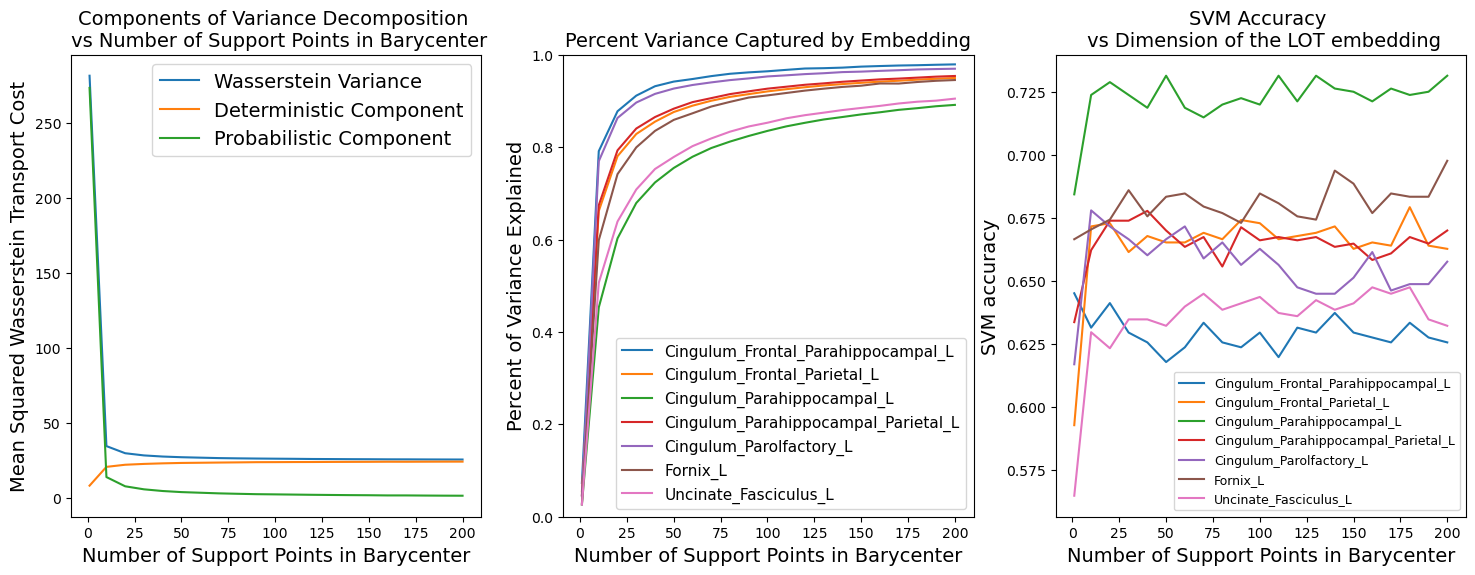

In [9]:
tract_temp = ['Cingulum_Frontal_Parahippocampal_L', 'Cingulum_Frontal_Parahippocampal_R', 'Cingulum_Frontal_Parietal_L', 'Cingulum_Frontal_Parietal_R', 'Cingulum_Parahippocampal_L', 
              'Cingulum_Parahippocampal_R', 'Cingulum_Parahippocampal_Parietal_L','Cingulum_Parahippocampal_Parietal_R', 'Cingulum_Parolfactory_L', 'Cingulum_Parolfactory_R', 'Fornix_L',
              'Fornix_R', 'Uncinate_Fasciculus_L', 'Uncinate_Fasciculus_R'] 

temp = []
import numpy as np
import matplotlib.pyplot as plt

K = np.concatenate((np.array([1]),np.arange(10,201,10)))

plt.figure(figsize=(18,6))

for tract in tract_temp:
    
    acc = np.load("data_files/acc_vs_k_experiment/"+tract+"_accuracy.npy")
    squared_wasserstein = np.load("data_files/acc_vs_k_experiment/"+tract+"_squared_wasserstein.npy")
    deterministic_component = np.load("data_files/acc_vs_k_experiment/"+tract+"_deterministic_component.npy")
    
    if tract[-1]=='L':
               
        if tract=='Fornix_L':
            plt.subplot(131)
            plt.plot(K,squared_wasserstein)
            plt.plot(K,deterministic_component)
            plt.plot(K,squared_wasserstein-deterministic_component)
            plt.legend(("Wasserstein Variance", "Deterministic Component", "Probabilistic Component"), fontsize=14)
            plt.title("Components of Variance Decomposition \n vs Number of Support Points in Barycenter", fontsize=14)
            plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
            plt.ylabel("Mean Squared Wasserstein Transport Cost", fontsize=14)
        
        plt.subplot(132)
        plt.plot(K,deterministic_component/squared_wasserstein)
        plt.title("Percent Variance Captured by Embedding", fontsize=14)
        plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
        plt.ylabel("Percent of Variance Explained", fontsize=14)
        plt.ylim(0,1)
        
        plt.subplot(133)
        plt.plot(K,acc)
        plt.title("SVM Accuracy \n vs Dimension of the LOT embedding", fontsize=14)
        plt.ylabel("SVM accuracy", fontsize=14)
        plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
        
        temp.append(tract)

plt.subplot(132)
plt.legend(temp, fontsize=11)

plt.subplot(133)
plt.legend(temp, fontsize=9)

# plt.show()
plt.savefig("dtmri_experiment",bbox_inches='tight')

In [10]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    acc = np.load("data_files/acc_vs_k_experiment/"+tract+"_accuracy.npy")
        
    print(tract,round(100*acc[0],2),round(100*acc[1],2),round(100*acc[5],2),round(100*acc[10],2),round(100*acc[20],2)) 

Cingulum_Frontal_Parahippocampal_L 64.52 63.16 61.79 62.96 62.57
Cingulum_Frontal_Parahippocampal_R 65.76 65.76 65.76 64.92 66.18
Cingulum_Frontal_Parietal_L 59.29 67.18 66.54 67.3 66.28
Cingulum_Frontal_Parietal_R 63.69 68.54 68.79 66.88 67.01
Cingulum_Parahippocampal_L 68.45 72.39 73.16 72.01 73.16
Cingulum_Parahippocampal_R 64.76 68.58 69.59 70.61 70.36
Cingulum_Parahippocampal_Parietal_L 63.38 66.23 67.01 66.62 67.01
Cingulum_Parahippocampal_Parietal_R 64.57 68.04 66.24 65.85 65.85
Cingulum_Parolfactory_L 61.7 67.81 66.67 66.28 65.78
Cingulum_Parolfactory_R 58.27 60.81 61.32 63.1 63.1
Fornix_L 66.67 67.06 68.35 68.48 69.78
Fornix_R 64.45 67.32 68.23 68.75 69.01
Uncinate_Fasciculus_L 56.49 62.98 63.23 64.38 63.23
Uncinate_Fasciculus_R 53.44 63.87 64.89 65.9 64.38


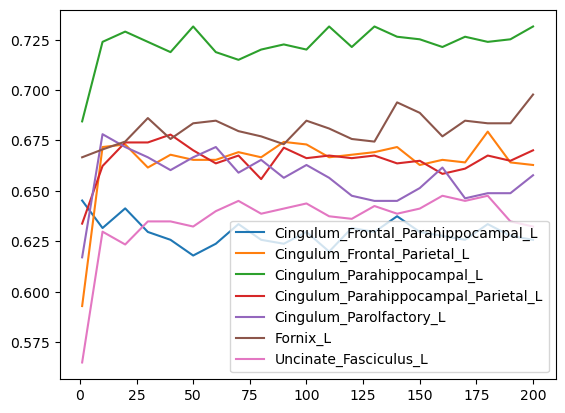

In [11]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    acc = np.load("data_files/acc_vs_k_experiment/"+tract+"_accuracy.npy")
    
    if tract[-1]=='L':
        plt.plot(K,acc)
        temp.append(tract)
    
plt.legend(temp)

plt.show()

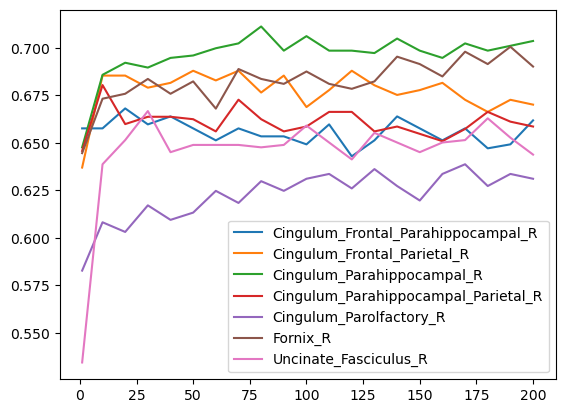

In [12]:
temp = []

for tract in tract_list:
    
    acc = np.load("data_files/acc_vs_k_experiment/"+tract+"_accuracy.npy")
    
    if tract[-1]=='R':
        plt.plot(K,acc)
        temp.append(tract)

    
plt.legend(temp)

plt.show()

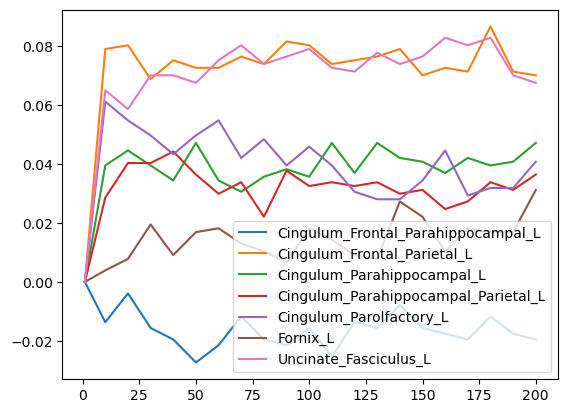

In [13]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    acc = np.load("data_files/acc_vs_k_experiment/"+tract+"_accuracy.npy")
    
    if tract[-1]=='L':
        plt.plot(K,acc-acc[0])
        temp.append(tract)
            
plt.legend(temp)

plt.show()

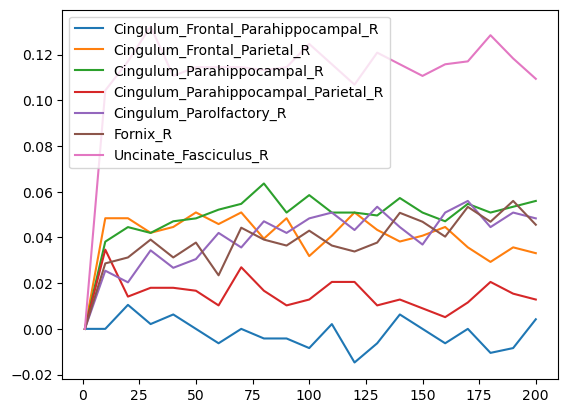

In [14]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    acc = np.load("data_files/acc_vs_k_experiment/"+tract+"_accuracy.npy")
    
    if tract[-1]=='R':
        plt.plot(K,acc-acc[0])
        temp.append(tract)
        
plt.legend(temp)

plt.show()

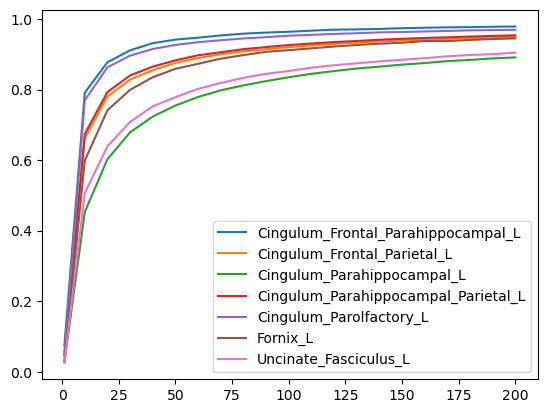

In [15]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    squared_wasserstein = np.load("data_files/acc_vs_k_experiment/"+tract+"_squared_wasserstein.npy")
    deterministic_component = np.load("data_files/acc_vs_k_experiment/"+tract+"_deterministic_component.npy")
    
    if tract[-1]=='L':
        plt.plot(K,deterministic_component/squared_wasserstein)
        temp.append(tract)

    
plt.legend(temp)

plt.show()

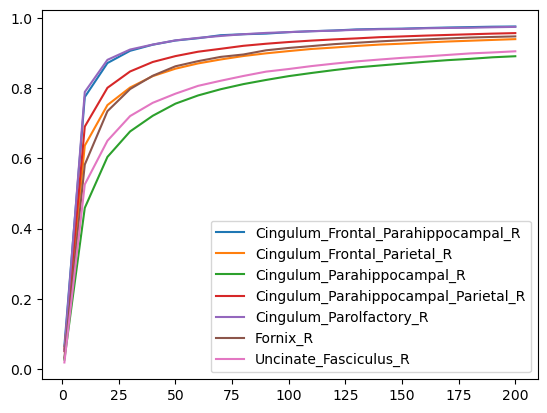

In [16]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    squared_wasserstein = np.load("data_files/acc_vs_k_experiment/"+tract+"_squared_wasserstein.npy")
    deterministic_component = np.load("data_files/acc_vs_k_experiment/"+tract+"_deterministic_component.npy")
    
    if tract[-1]=='R':
        plt.plot(K,deterministic_component/squared_wasserstein)
        temp.append(tract)

    
plt.legend(temp)

plt.show()

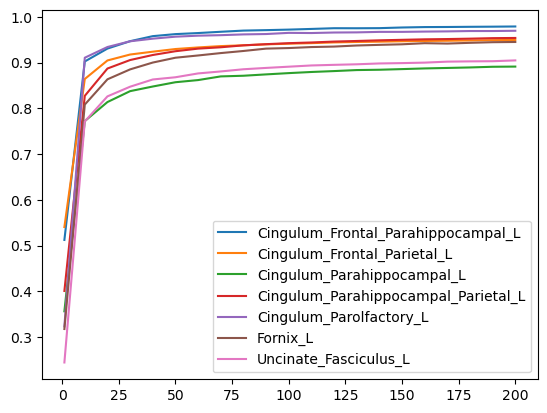

In [17]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    squared_wasserstein = np.load("data_files/acc_vs_k_experiment/"+tract+"_squared_wasserstein.npy")
    deterministic_component = np.load("data_files/acc_vs_k_experiment/"+tract+"_deterministic_component.npy")
    
    if tract[-1]=='L':
        plt.plot(K,deterministic_component/squared_wasserstein[-1])
        temp.append(tract)

    
plt.legend(temp)

plt.show()

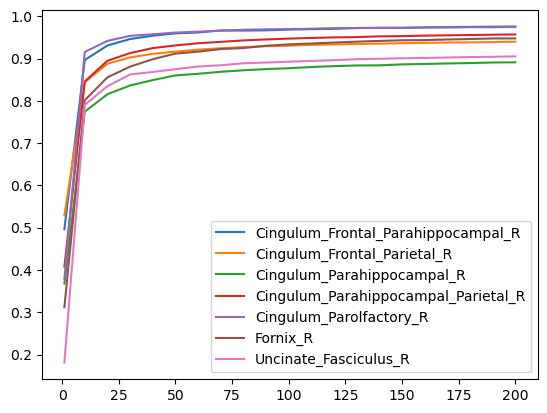

In [18]:
tract_list = list(df.columns[2:12])+list(df.columns[16:18])+list(df.columns[24:-1])
temp = []

for tract in tract_list:
    
    squared_wasserstein = np.load("data_files/acc_vs_k_experiment/"+tract+"_squared_wasserstein.npy")
    deterministic_component = np.load("data_files/acc_vs_k_experiment/"+tract+"_deterministic_component.npy")
    
    if tract[-1]=='R':
        plt.plot(K,deterministic_component/squared_wasserstein[-1])
        temp.append(tract)

    
plt.legend(temp)

plt.show()